# 3D CT Image Segmentation using MONAI 
## Dataset link: https://zenodo.org/record/7262581

In [3]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
import os
from glob import glob
import multiprocessing
from monai.transforms import (
    Compose,
    LoadImaged,
    ToTensord,
    AddChanneld,
    Spacingd,
    ScaleIntensityRanged,
    CropForegroundd,
    Resized,
    EnsureChannelFirstd,
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    RandAffined,
    RandRotated,
    RandGaussianNoised,
    RandCropByPosNegLabeld,
    RandRotate90d,
    ResizeWithPadOrCropd
)
import torch


from monai.data import Dataset, CacheDataset, DataLoader, decollate_batch
from monai.utils import first
num_workers = multiprocessing.cpu_count()
print(num_workers)

from pathlib import Path
dataset_dir = '.'
print('Last run on', time.ctime())


24
Last run on Fri Dec 23 18:31:10 2022


### Checking one image

In [4]:
import numpy as np
import nibabel as nib


image_path = "./imagesTr/amos_0001.nii.gz"
image_obj = nib.load(image_path)

label_path = "./labelsTr/amos_0001.nii.gz"
label_obj = nib.load(label_path)

print(f'Type of the image {type(image_obj)}')
print(f'Type of the label {type(label_obj)}')

# Extract data as numpy ndarray
image_data = image_obj.get_fdata()

label_array = label_obj.get_fdata()

# Get the image shape and print it out
height, width, depth = image_data.shape
print(f"The image object has the following dimensions: height: {height}, width:{width}, depth:{depth}")

height, width, depth = label_array.shape
print(f"The image object has the following dimensions: height: {height}, width:{width}, depth:{depth}")

print(f'With the unique values: {np.unique(label_array)}')

device = torch.device("cuda:0")


Type of the image <class 'nibabel.nifti1.Nifti1Image'>
Type of the label <class 'nibabel.nifti1.Nifti1Image'>
The image object has the following dimensions: height: 768, width:768, depth:90
The image object has the following dimensions: height: 768, width:768, depth:90
With the unique values: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


### Loading the dataset

In [5]:
import json

f = open('./dataset.json')      #JSON file is provided
dataJson = json.load(f)
train_list = dataJson['training']
train_list = train_list[0:200]

print(len(train_list))
test_list = dataJson['validation']
test_list = test_list[0:100]
print(len(test_list))

200
100


### Read a CT image and the corresponding label

In [6]:
import SimpleITK as sitk

idx = 0 
img = sitk.ReadImage(train_list[idx]['image'])
lab = sitk.ReadImage(train_list[idx]['label'])
print(img.GetSpacing(),img.GetSize(), img.GetDirection())
print(lab.GetSpacing(),lab.GetSize(), lab.GetDirection())

(0.5703125, 0.5703125, 5.0) (768, 768, 90) (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
(0.5703125, 0.5703125, 5.0) (768, 768, 90) (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)


In [7]:
print(sitk.GetArrayFromImage(img).dtype, sitk.GetArrayFromImage(lab).dtype)
print(np.unique(sitk.GetArrayFromImage(lab)))

float32 uint16
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [8]:
df_dict = {'img_path': [], 'size':[], 'spacing': []}
for idx, path_dict in enumerate(train_list):
    img_path = path_dict['image']
    img = sitk.ReadImage(img_path)
    df_dict['img_path'].append(img_path)
    df_dict['size'].append(sitk.GetArrayFromImage(img))
    df_dict['spacing'].append(img.GetSpacing())

In [9]:
import pandas as pd
df = pd.DataFrame.from_dict(df_dict)

for i in range(3):
    df[f'size_{i}'] = df['size'].apply(lambda x: x[i])
for i in range(3):
    df[f'spacing_{i}'] = df['spacing'].apply(lambda x: x[i])
df.describe()

,spacing_0,spacing_1,spacing_2
count,200.000000,200.000000,200.000000
mean,0.704425,0.704425,4.383750
std,0.127984,0.127984,1.222146
min,0.453125,0.453125,1.250000
25%,0.610352,0.610352,5.000000
50%,0.688250,0.688250,5.000000
75%,0.782000,0.782000,5.000000
max,1.068000,1.068000,5.000000


In [10]:
sitk.IntensityWindowing

<function SimpleITK.SimpleITK.IntensityWindowing(image1, windowMinimum=0.0, windowMaximum=255.0, outputMinimum=0.0, outputMaximum=255.0)>

### Splitting the dataset

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

train, val = train_test_split(train_list, test_size=0.1)

### Defining the preprocessing

In [12]:
#ResizeWithPadOrCropd

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,     #For these values see the reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7790158/table/t001/
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ResizeWithPadOrCropd(keys=["image", "label"],
                             spatial_size =(224,224,224),   #These values can be experimented with
                             mode='constant'),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        )
    ]
)

### Visualizing different layers of the one CT image

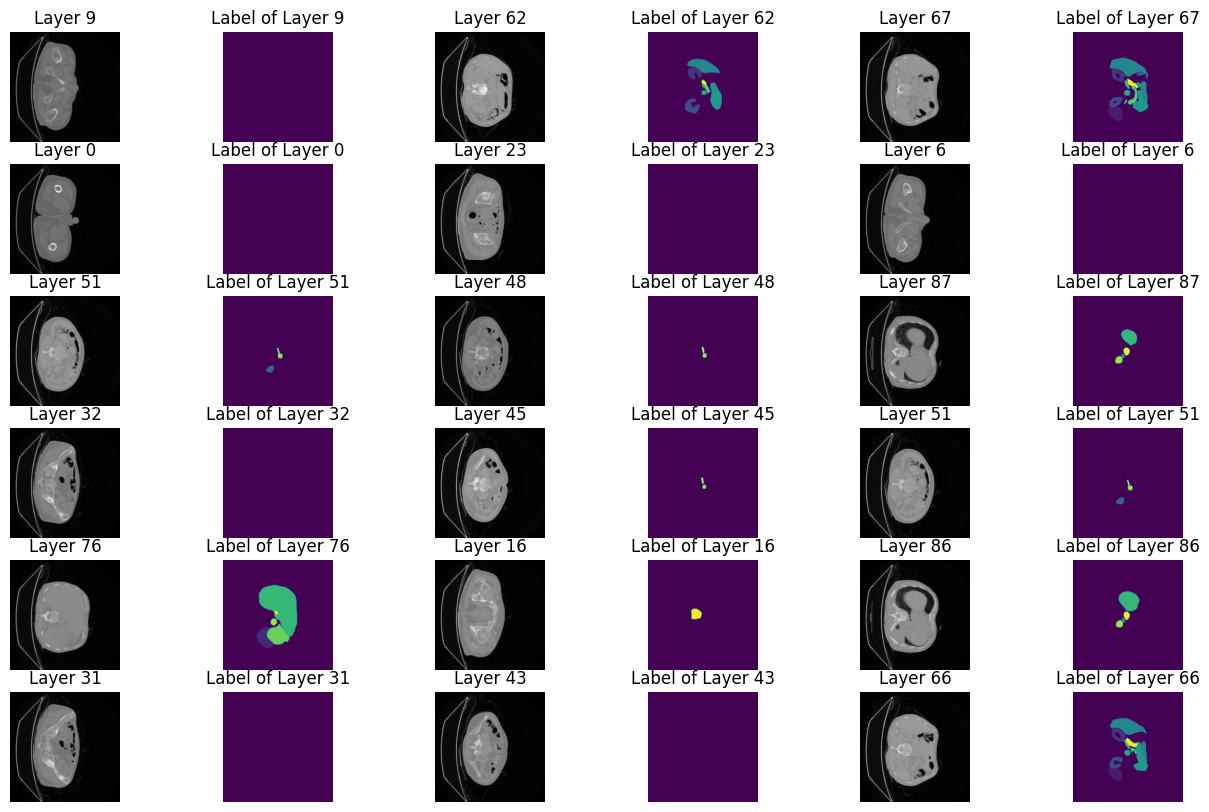

In [13]:
# Select random layer number
maxval = 89

#print(f"Plotting Layer {i} of the first grayscale Image")
#plt.figure("image", (24, 6))
plt.figure("image", (16, 10))
a = 1
for row in range(36):
        i = np.random.randint(0, maxval)
        if(a>36):
                break
        plt.subplot(6, 6, a)
        plt.title(f"Layer {i}")
        plt.imshow(image_data[:, :, i], cmap='gray')
        plt.axis('off')
        if(a>36):
                break
        plt.subplot(6, 6, a+1)
        plt.title(f"Label of Layer {i}")
        plt.imshow(label_array[:, :, i])
        plt.axis('off')
        a+=2
#plt.axis('off')

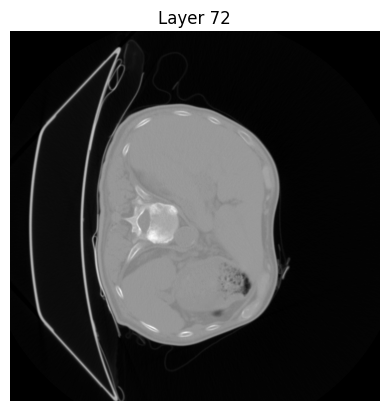

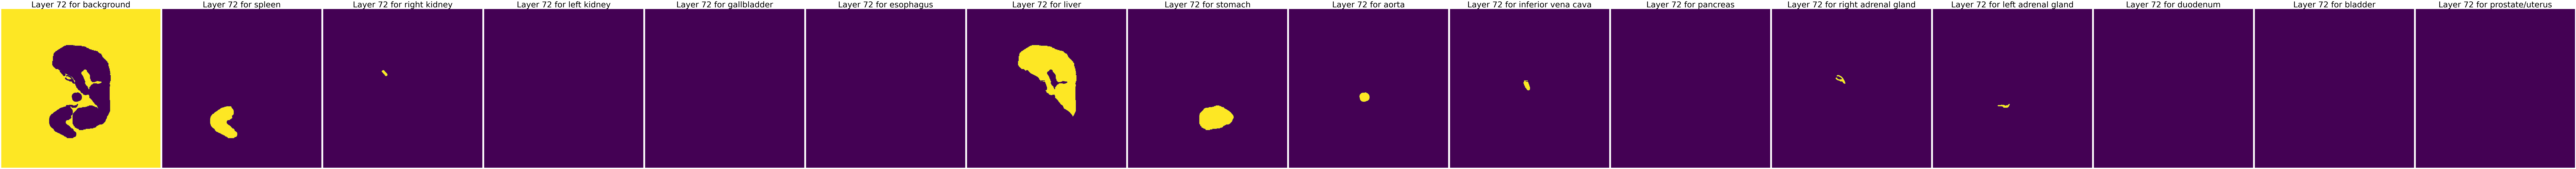

In [14]:
# Define a dictionary of class labels
classes_dict = {
    'background': 0.,
    'spleen': 1.,
    'right kidney': 2.,
    'left kidney': 3.,
    'gallbladder': 4.,
    'esophagus': 5.,
    'liver': 6.,
    'stomach': 7.,
    'aorta': 8.,
    'inferior vena cava': 9.,
    'pancreas': 10.,
    'right adrenal gland': 11.,
    'left adrenal gland': 12.,
    'duodenum': 13.,
    'bladder': 14.,
    'prostate/uterus': 15.,
     
}

# Define a single layer for plotting
# layer = np.random.randint(0, maxval)
layer = 72
plt.title(f"Layer {layer}")
plt.imshow(image_data[:, :, layer], cmap='gray')
plt.axis('off')

# Set up for plotting
fig, ax = plt.subplots(nrows=1, ncols=16, figsize=(200, 30))
#layer 67 is good for checking
for i in range(16):
    img_label_str = list(classes_dict.keys())[i]
    img = label_array[:,:,layer]
    mask = np.where(img == classes_dict[img_label_str], 255, 0)
    ax[i].imshow(mask)
    ax[i].set_title(f"Layer {layer} for {img_label_str}", fontsize=45)
    ax[i].axis('off')
plt.tight_layout()

### Creating the datsets for the training

In [15]:
#If anyone wnats to use Dataset instead of CacheDataset just have to uncomment this cell

# train_ds = Dataset(training, transform=train_transforms)
# train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,num_workers=num_workers, drop_last=True)

# val_ds = Dataset(data=validation, transform=val_transforms)
# val_loader = DataLoader(val_ds, batch_size=4, shuffle=False,num_workers=num_workers,drop_last=True)

In [16]:
train_ds = CacheDataset(train, transform=train_transforms, cache_num=24, cache_rate=1.0, num_workers=num_workers)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=num_workers)

val_ds = CacheDataset(data=val, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=num_workers)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=num_workers)

Loading dataset: 100%|██████████| 6/6 [00:40<00:00,  6.75s/it]


In [17]:
test_ds = Dataset(data=test_list, transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False,num_workers=num_workers)

In [18]:
test_patient = first(train_loader)
print(test_patient['image'].shape)
print(test_patient['label'].shape)

(4, 1, 96, 96, 96)
(4, 1, 96, 96, 96)


In [19]:
test_patient1 = first(val_loader)
print(test_patient1['image'].shape)
print(test_patient1['label'].shape)

(1, 1, 282, 188, 304)
(1, 1, 282, 188, 304)


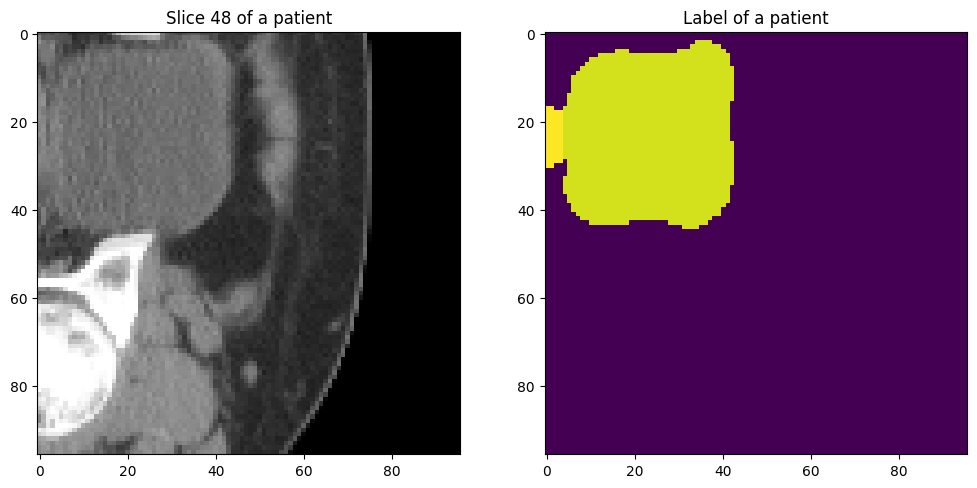

In [24]:

plt.figure('test', (12, 6))

layer = np.random.randint(0, 64)

plt.subplot(1, 2, 1)
plt.title(f'Slice {layer} of a patient')
plt.imshow(test_patient['image'][0, 0, : ,: ,layer], cmap= "gray")

plt.subplot(1,2,2)
plt.title('Label of a patient')
plt.imshow(test_patient['label'][0, 0, : ,: ,layer])
plt.show()

### Defining the model
#### Other models have been commented, one can eawsily use them by uncommenting

In [20]:
max_epochs = 200
val_interval = 5
VAL_AMP = True

In [21]:
from monai.networks.nets import SwinUNETR
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.networks.nets import AttentionUnet
from monai.networks.nets import UNETR
import torch.nn as nn

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=16,
    feature_size=48,
    use_checkpoint=True,
).to(device)

# model = UNet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=16,
#     channels=(16, 32, 64, 128, 256),
#     strides=(2, 2, 2, 2),
#     num_res_units=2,
#     norm=Norm.BATCH,
# ).to(device)

# model = AttentionUnet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=16,
#     channels=(16, 32, 64, 128, 256),
#     strides=(2, 2, 2, 2),
# ).to(device)

# model = UNETR(
#     img_size=(96, 96, 96),
#     in_channels=1,
#     out_channels=16,
#     feature_size=48,
#     norm_name='batch',
# ).to(device)

In [22]:
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric

In [23]:
from monai.losses import DiceCELoss

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
#lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)


In [24]:
from monai.metrics import DiceMetric

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")     # to get the dice values of all classes

In [25]:
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
)

In [27]:
# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

In [28]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=16)])
post_label = Compose([AsDiscrete(to_onehot=16)])        #15 organs and background

### Training

In [29]:
val_nums = int(max_epochs/val_interval)

diffmetric =  [[] for i in range(val_nums)]
total_start = time.time()


for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        
        #optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            logit_map = model(inputs)
            loss = loss_function(logit_map, labels)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
        #lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():

            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

                

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            #for calculaitng mean value for all class
            metric_batch = dice_metric_batch.aggregate()
            for i in range(15):
                diffmetric[i].append(metric_batch[i].item())
            dice_metric.reset()
            dice_metric_batch.reset()
            

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(dataset_dir, "best_metric_modelSwinUnetR.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start


----------
epoch 1/200
1/180, train_loss: 4.1318, step time: 13.1585
2/180, train_loss: 3.9657, step time: 0.8617
3/180, train_loss: 3.8513, step time: 0.8290
4/180, train_loss: 3.7451, step time: 0.8852
5/180, train_loss: 3.6962, step time: 0.8272
6/180, train_loss: 3.5992, step time: 0.6761
7/180, train_loss: 3.5049, step time: 0.7168
8/180, train_loss: 3.4757, step time: 0.8457
9/180, train_loss: 3.4402, step time: 0.7564
10/180, train_loss: 3.3810, step time: 0.6647
11/180, train_loss: 3.3876, step time: 0.8615
12/180, train_loss: 3.2531, step time: 0.9054
13/180, train_loss: 3.2265, step time: 0.6675
14/180, train_loss: 3.3058, step time: 0.6721
15/180, train_loss: 3.2728, step time: 0.6912
16/180, train_loss: 3.1443, step time: 0.6701
17/180, train_loss: 3.1237, step time: 0.6683
18/180, train_loss: 3.1869, step time: 0.7209
19/180, train_loss: 3.0844, step time: 0.8260
20/180, train_loss: 3.0941, step time: 0.8159
21/180, train_loss: 3.1235, step time: 0.8397
22/180, train_loss:

None of the inputs have requires_grad=True. Gradients will be None


saved new best metric model
current epoch: 5 current mean dice: 0.1588
best mean dice: 0.1588 at epoch: 5
time consuming of epoch 5 is: 345.9375
----------
epoch 6/200
1/180, train_loss: 1.3075, step time: 0.8490
2/180, train_loss: 1.3569, step time: 0.7858
3/180, train_loss: 1.3942, step time: 0.8339
4/180, train_loss: 1.5249, step time: 0.6719
5/180, train_loss: 1.6072, step time: 0.7166
6/180, train_loss: 1.2945, step time: 0.8144
7/180, train_loss: 1.4831, step time: 0.8278
8/180, train_loss: 1.4227, step time: 0.8197
9/180, train_loss: 1.2949, step time: 0.8464
10/180, train_loss: 1.4393, step time: 0.7779
11/180, train_loss: 1.5355, step time: 0.6953
12/180, train_loss: 1.4111, step time: 0.6938
13/180, train_loss: 1.4191, step time: 0.6998
14/180, train_loss: 1.3534, step time: 0.6932
15/180, train_loss: 2.1936, step time: 0.6996
16/180, train_loss: 1.5884, step time: 0.7505
17/180, train_loss: 1.2002, step time: 0.8555
18/180, train_loss: 1.3673, step time: 0.9229
19/180, train

In [30]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")


train completed, best_metric: 0.8455 at epoch: 200


### Visualization of the validation datset result

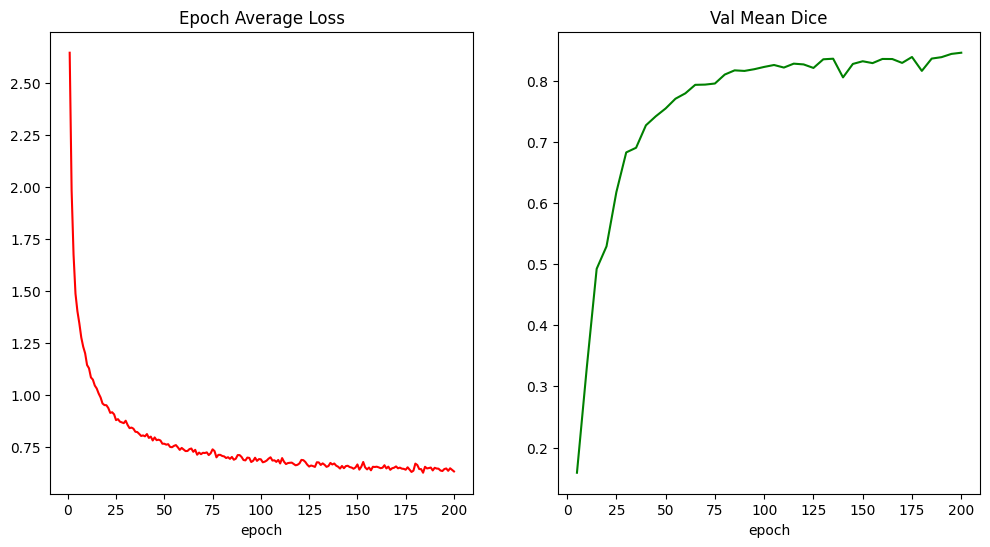

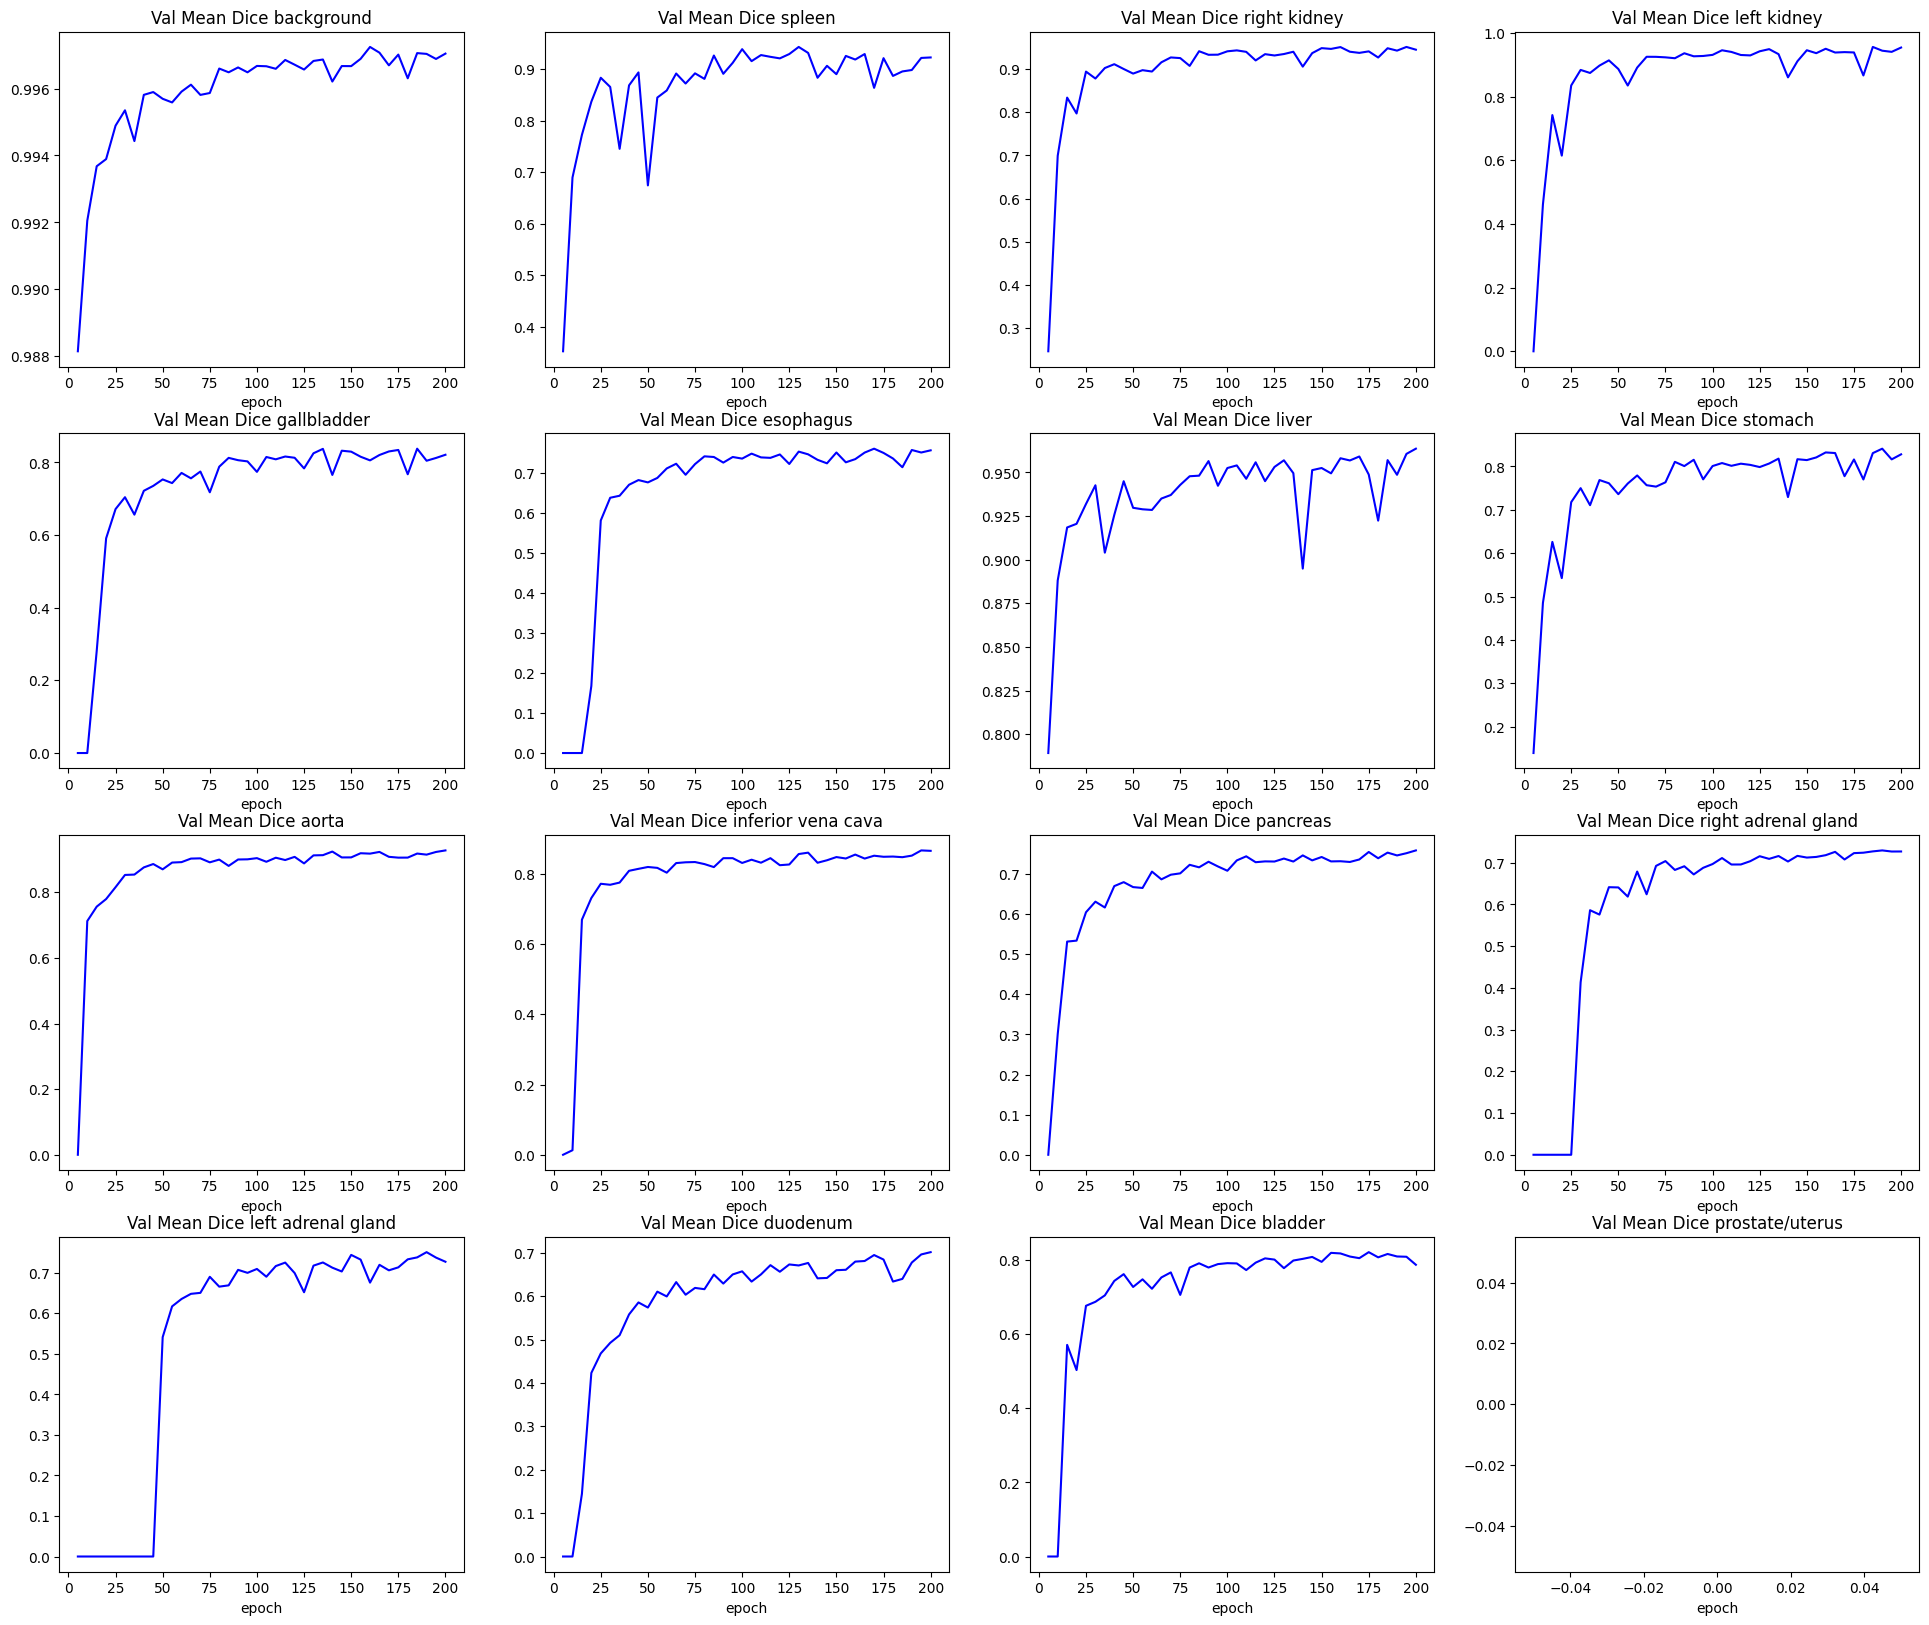

In [31]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (24, 20))

for i in range(16):
    img_label_str = list(classes_dict.keys())[i]
    plt.subplot(4, 4, i+1)
    plt.title(f"Val Mean Dice {img_label_str}")
    x = [val_interval * (i + 1) for i in range(len(diffmetric[i]))]
    y = diffmetric[i]
    plt.xlabel("epoch")
    plt.plot(x, y, color="blue")

### Evaluating the model on test dataset

In [32]:
model.load_state_dict(torch.load(os.path.join(dataset_dir, "best_metric_modelSwinUnetR.pth")))
model.eval()

sw_batch_size = 4
roi_size = (128, 128, 64)
case_num = 4

In [33]:
from monai.metrics import HausdorffDistanceMetric

hd95 = HausdorffDistanceMetric(include_background=True, percentile=95)        #95 HD

In [34]:
with torch.no_grad():
    for test_data in test_loader:
        test_inputs, test_labels = (
            test_data["image"].to(device),
            test_data["label"].to(device),
        )
        test_outputs = sliding_window_inference(test_inputs, (96, 96, 96), 4, model)
        test_outputs = [post_pred(i) for i in decollate_batch(test_outputs)]
        test_labels = [post_label(i) for i in decollate_batch(test_labels)]
        dice_metric(y_pred=test_outputs, y=test_labels)
        dice_metric_batch(y_pred=test_outputs, y=test_labels)
        hd95(y_pred=test_outputs, y=test_labels)
    metric = dice_metric.aggregate().item()
    print(f"Dice metric on test dataset {metric}")
    metrichd = hd95.aggregate().item()
    print(f"Hausdorff distance 95 on test dataset {metrichd}")

    metric_batch = dice_metric_batch.aggregate()
    for i in range(16):
        img_label_str = list(classes_dict.keys())[i]
        print(f"Mean Dice {img_label_str}: {metric_batch[i].item()}")


the ground truth of class 15 is all 0, this may result in nan/inf distance.
invalid value encountered in subtract
the ground truth of class 4 is all 0, this may result in nan/inf distance.
the ground truth of class 13 is all 0, this may result in nan/inf distance.
the prediction of class 4 is all 0, this may result in nan/inf distance.
the ground truth of class 2 is all 0, this may result in nan/inf distance.
the ground truth of class 14 is all 0, this may result in nan/inf distance.
the prediction of class 14 is all 0, this may result in nan/inf distance.
the prediction of class 15 is all 0, this may result in nan/inf distance.
the ground truth of class 7 is all 0, this may result in nan/inf distance.


Dice metric on test dataset 0.8614961504936218
Hausdorff distance 95 on test dataset 13.91063363938902
Mean Dice background: 0.9968087077140808
Mean Dice spleen: 0.9326725602149963
Mean Dice right kidney: 0.9482816457748413
Mean Dice left kidney: 0.9359169006347656
Mean Dice gallbladder: 0.8265718221664429
Mean Dice esophagus: 0.7950014472007751
Mean Dice liver: 0.9665778279304504
Mean Dice stomach: 0.8874692916870117
Mean Dice aorta: 0.934050440788269
Mean Dice inferior vena cava: 0.8848044872283936
Mean Dice pancreas: 0.8297500610351562
Mean Dice right adrenal gland: 0.7409824132919312
Mean Dice left adrenal gland: 0.7365583181381226
Mean Dice duodenum: 0.774817705154419
Mean Dice bladder: 0.7977799773216248
Mean Dice prostate/uterus: 0.7930908203125
